# Minstrel-Plus-retry-once Analysis

# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get the packet data

In [2]:
all_packets_path = "minstrel_plus-retry-once/ap_all_packets.csv"
all_packets = pd.read_csv(all_packets_path)
station_packets_path = "minstrel_plus-retry-once/sta_all_packets.csv"
sta_packets = pd.read_csv(station_packets_path)

### We extract only the packets satisfying the criterion (Protocol == UDP)

In [3]:
filter_condition1 = all_packets["Protocol"] == "UDP"
filter_condition2 = sta_packets["Protocol"] == "UDP"
udp_packets = all_packets[filter_condition1 == True]
sta_packets = sta_packets[filter_condition2 == True]

### Just check the total number of UDP packets

In [4]:
print(len(udp_packets))
print(len(sta_packets))

161334
151021


### Take a quick look at the dataframe

In [5]:
print(udp_packets.head())

    No.      Time       Source  Destination Protocol  Length  Sequence number  \
15   16  0.407359  192.168.1.1  192.168.1.2      UDP    1524              0.0   
16   17  0.407359  192.168.1.1  192.168.1.2      UDP    1524              1.0   
17   18  0.407359  192.168.1.1  192.168.1.2      UDP    1524              2.0   
18   19  0.407359  192.168.1.1  192.168.1.2      UDP    1524              3.0   
19   20  0.407359  192.168.1.1  192.168.1.2      UDP    1524              4.0   

    MCS index  A-MPDU reference number                             Retry  
15        6.0                      0.0  Frame is not being retransmitted  
16        6.0                      0.0  Frame is not being retransmitted  
17        6.0                      0.0  Frame is not being retransmitted  
18        6.0                      0.0  Frame is not being retransmitted  
19        6.0                      0.0  Frame is not being retransmitted  


# Extract the necessary columns

In [6]:
time = udp_packets["Time"]
sequence_numbers = udp_packets["Sequence number"]
retries = udp_packets["Retry"]
mcs_values = udp_packets["MCS index"]
#data = udp_packets["Length"]
ampdu_ref = udp_packets["A-MPDU reference number"]

sta_time = sta_packets["Time"]
sta_data = sta_packets["Length"]

### We extract the columns that we require for our analysis
### The columns we are interested are:
- Time
- Sequence number
- Retry
- MCS index
- Length
- A-MPDU reference number

In [7]:
print(sequence_numbers.isna().sum())

0


### Check to see if any packets are missing sequence numbers

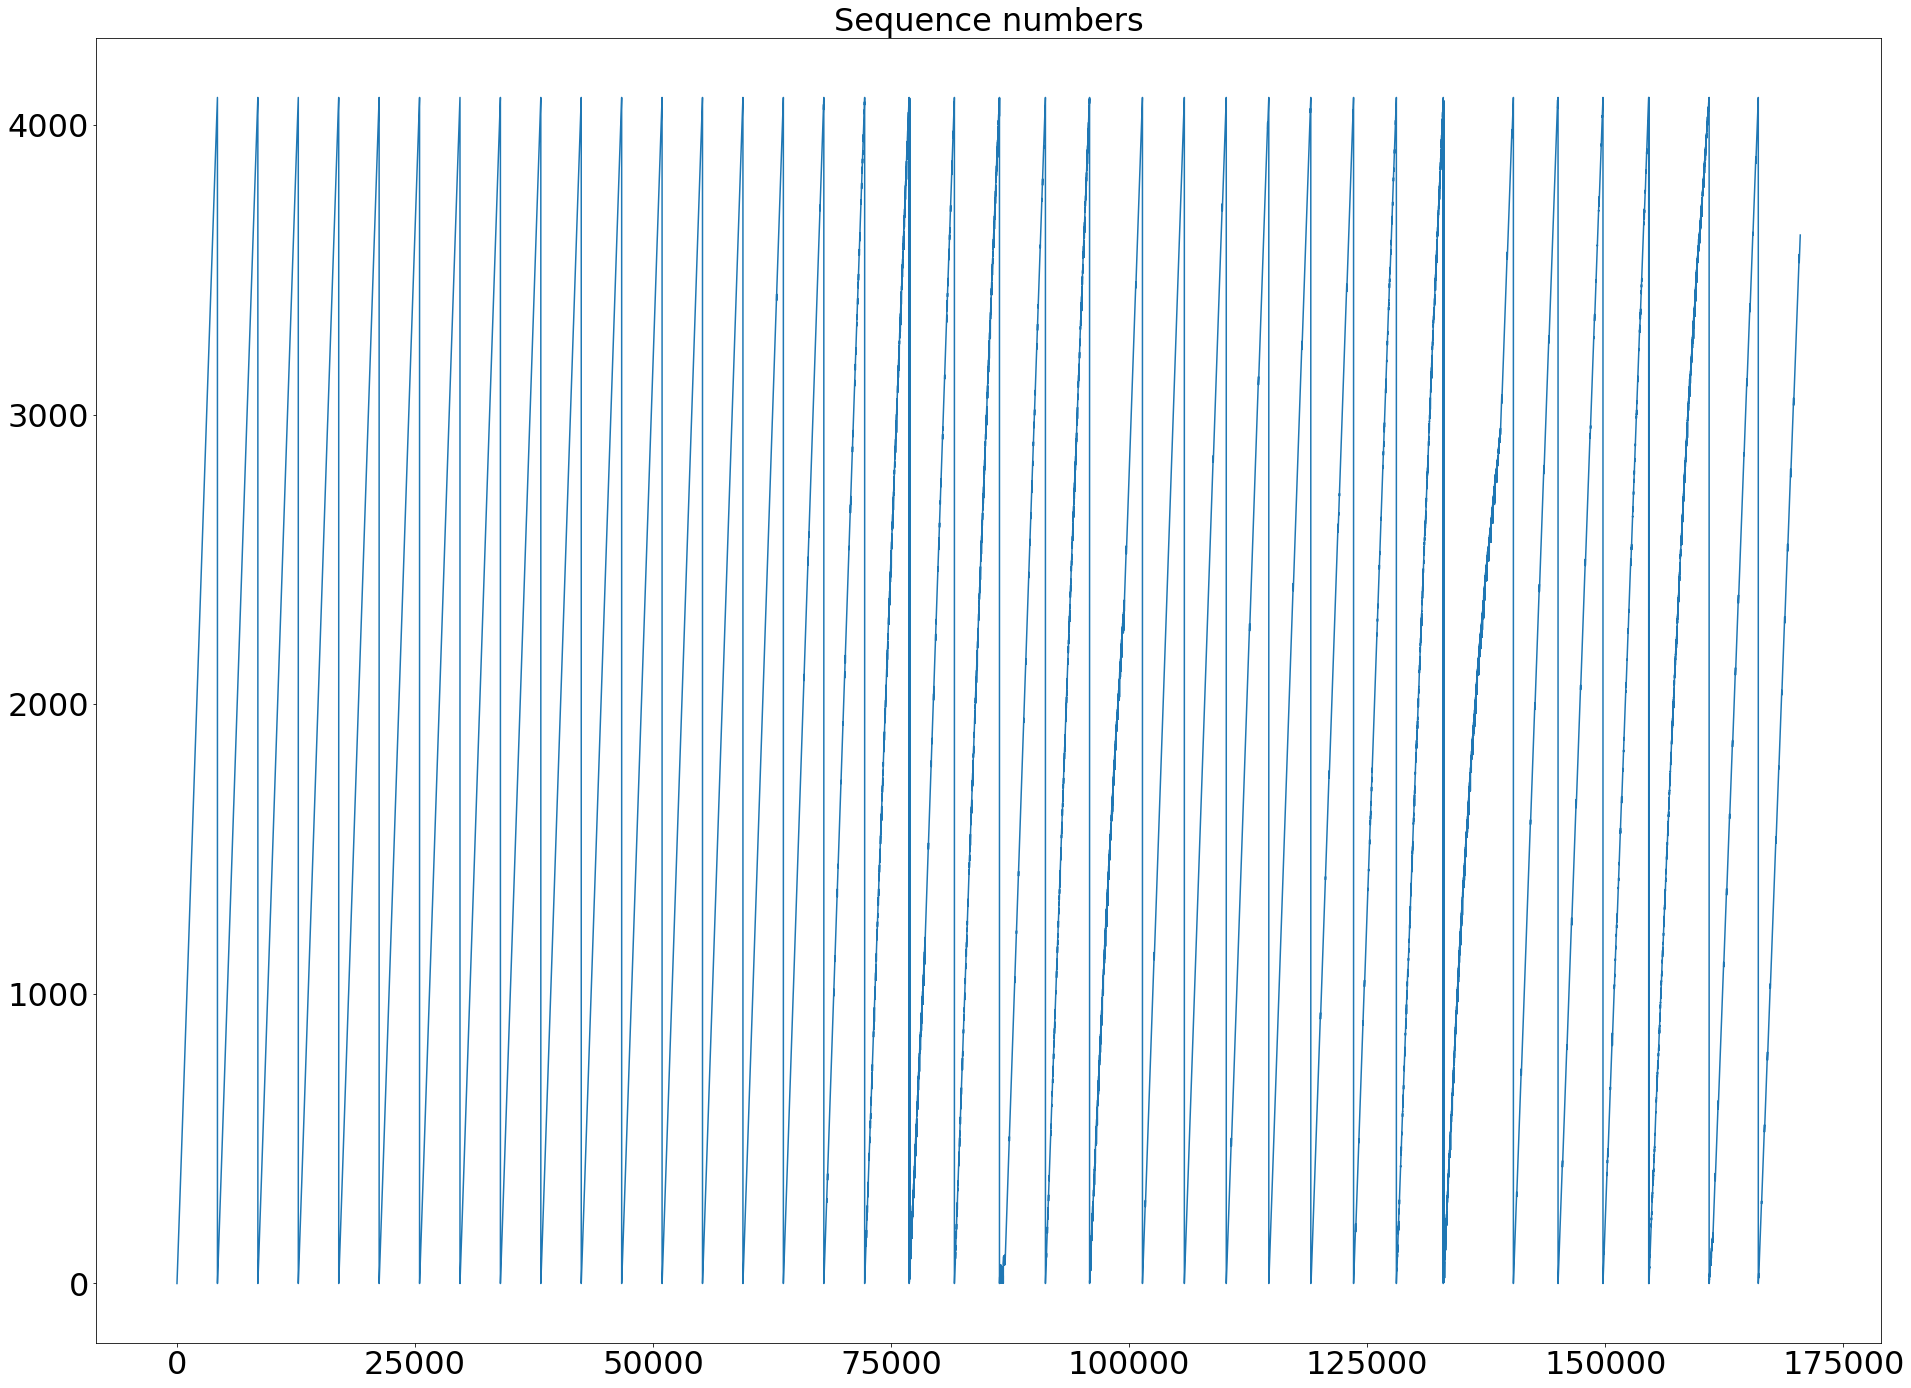

In [8]:
plt.figure(figsize=(32, 24))
plt.plot(sequence_numbers)
plt.title("Sequence numbers", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.show()

### Convert the modulo 2^12 sequence number to a rolling sequence number so that every packet has a unique sequence number

In [9]:
def unroll(seq_nums):
    max_seq_num = 4096
    transition_region = max_seq_num/4
    transition_threshold = max_seq_num/2
    counter = 0
    counter_hyst = 0
    new_seq_num = []
    
    for _, seq_num in seq_nums.items():
        if seq_num >= 0 and seq_num <= transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + counter*max_seq_num)
        elif seq_num > transition_threshold and counter_hyst != 0:
            new_seq_num.append(seq_num + (counter - 1)*max_seq_num)
        else:
            new_seq_num.append(seq_num + counter*max_seq_num)
            
        if seq_num == max_seq_num - 1 and counter_hyst == 0:
            counter += 1
            counter_hyst = 1
        elif counter_hyst > 0:
            counter_hyst += 1
        
        if counter_hyst >= transition_region:
            counter_hyst = 0
            
    udp_packets["New Sequence number"] = new_seq_num

In [10]:
unroll(sequence_numbers)

/home/EU/dedevarr/NS3-analysis/nsvenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
new_sequence_numbers = udp_packets["New Sequence number"]

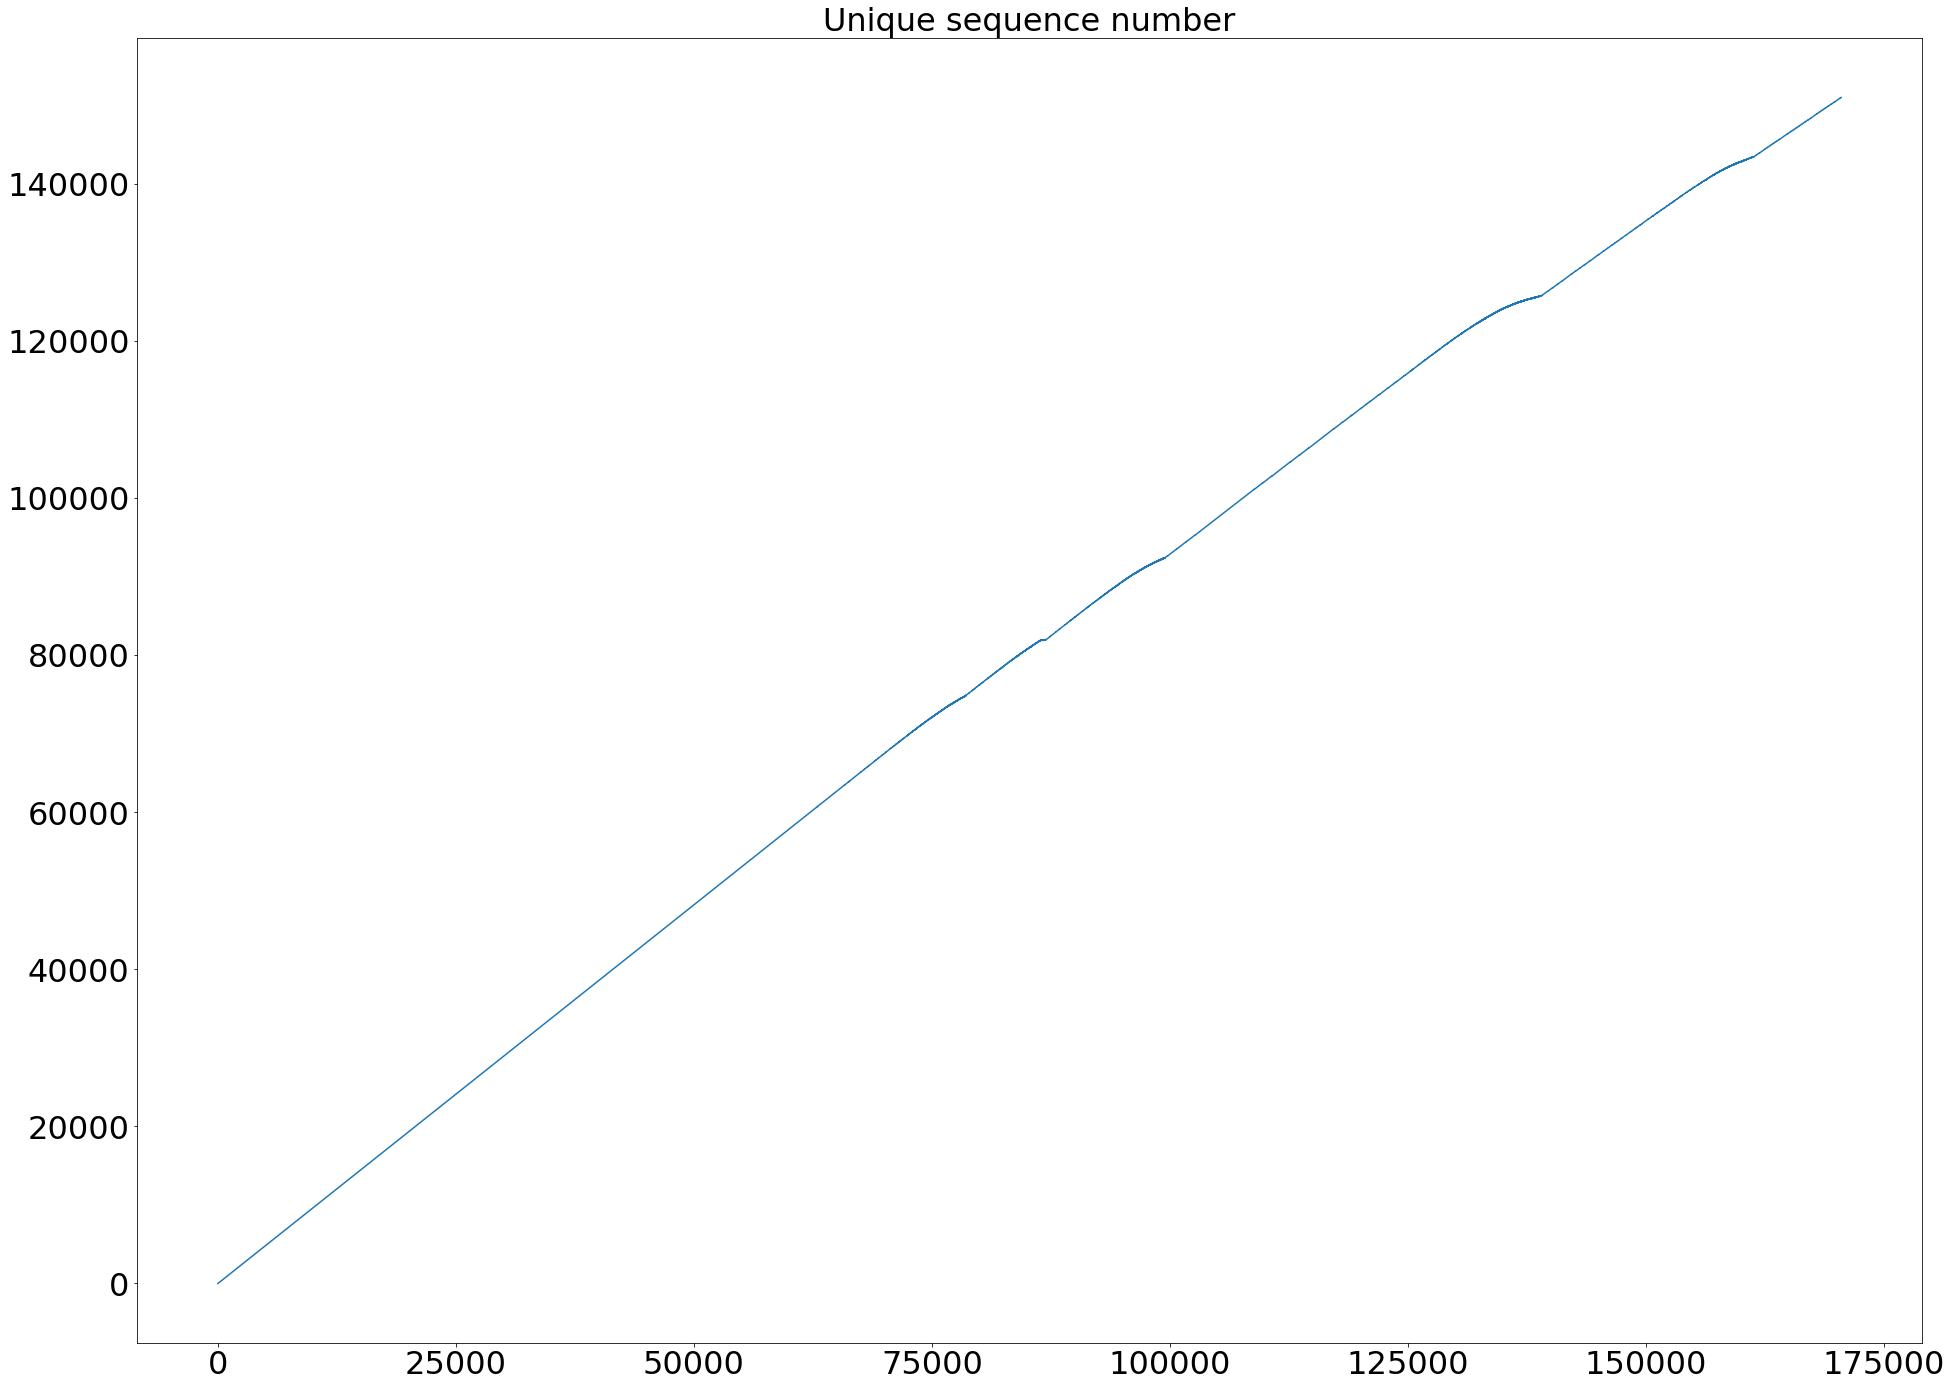

In [12]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers)
plt.title("Unique sequence number", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.show()

In [13]:
print(udp_packets.head())

    No.      Time       Source  Destination Protocol  Length  Sequence number  \
15   16  0.407359  192.168.1.1  192.168.1.2      UDP    1524              0.0   
16   17  0.407359  192.168.1.1  192.168.1.2      UDP    1524              1.0   
17   18  0.407359  192.168.1.1  192.168.1.2      UDP    1524              2.0   
18   19  0.407359  192.168.1.1  192.168.1.2      UDP    1524              3.0   
19   20  0.407359  192.168.1.1  192.168.1.2      UDP    1524              4.0   

    MCS index  A-MPDU reference number                             Retry  \
15        6.0                      0.0  Frame is not being retransmitted   
16        6.0                      0.0  Frame is not being retransmitted   
17        6.0                      0.0  Frame is not being retransmitted   
18        6.0                      0.0  Frame is not being retransmitted   
19        6.0                      0.0  Frame is not being retransmitted   

    New Sequence number  
15                  0.0  
16  

In [14]:
num_retries = np.zeros(len(udp_packets))

### Count the number of retries for each MPDU. Each MPDU will have a unique sequence number. Each packet has a retry flag that indicates if it a retransmit or not

In [15]:
for i in range(0, len(udp_packets)):
    unique_sequence_number = int(new_sequence_numbers.iloc[i])
    if retries.iloc[i] == "Frame is being retransmitted":
        num_retries[unique_sequence_number] += 1

In [16]:
print(num_retries.min())
print(num_retries.max())

0.0
29.0


### Plot the number of retries per each MPDU. 
### x axis ----> Unique sequence number  
### y axis ----> Number of retransmits 

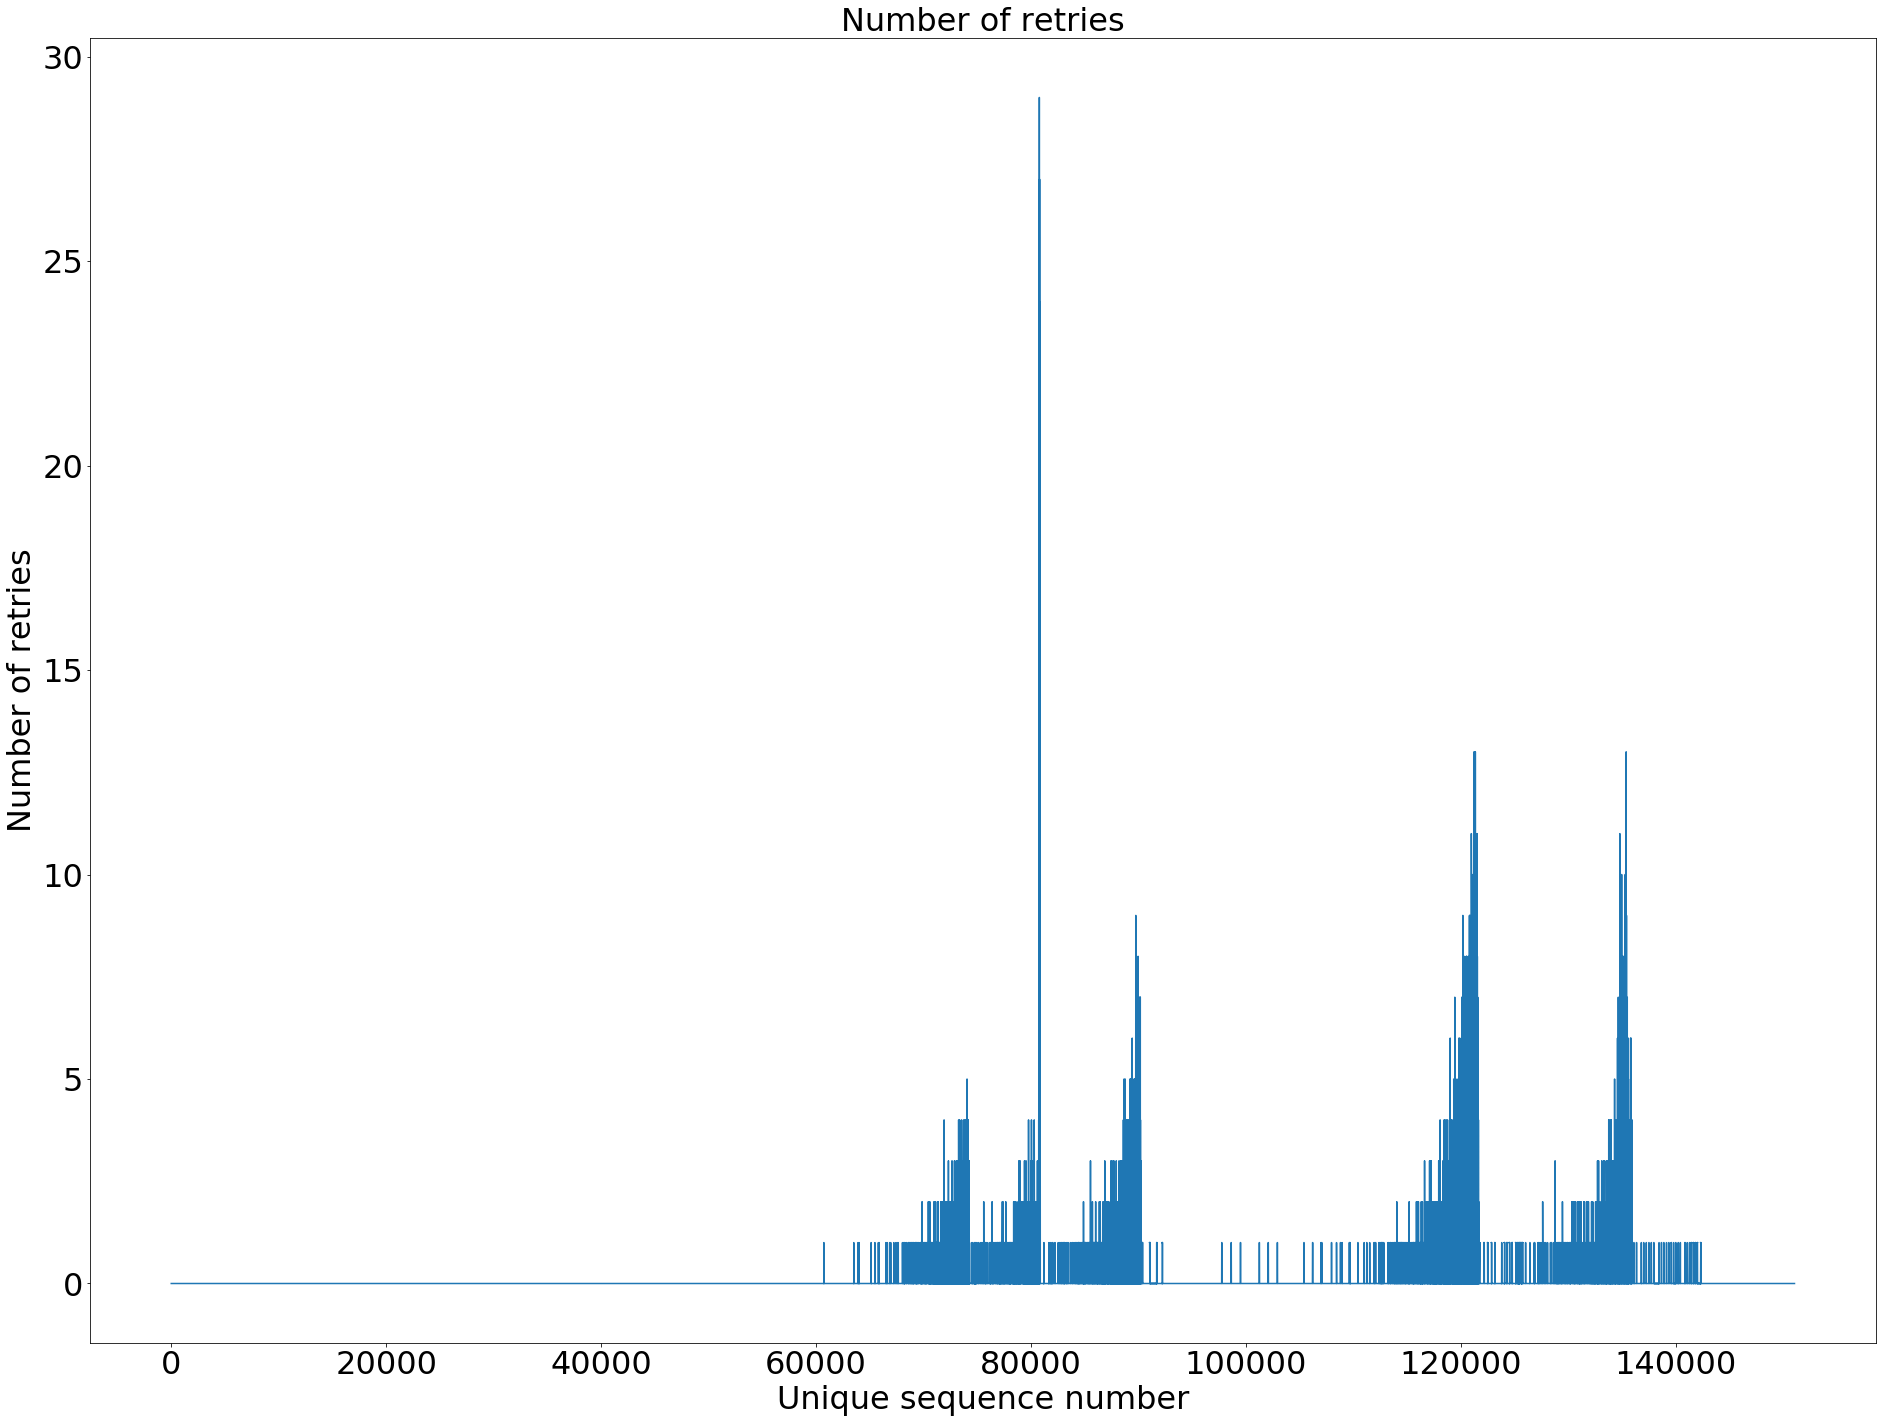

In [17]:
plt.figure(figsize=(32, 24))
plt.plot(new_sequence_numbers, num_retries)
plt.title("Number of retries", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Unique sequence number", fontsize=32)
plt.ylabel("Number of retries", fontsize=32)
plt.show()

### Plot the MCS index of each packet

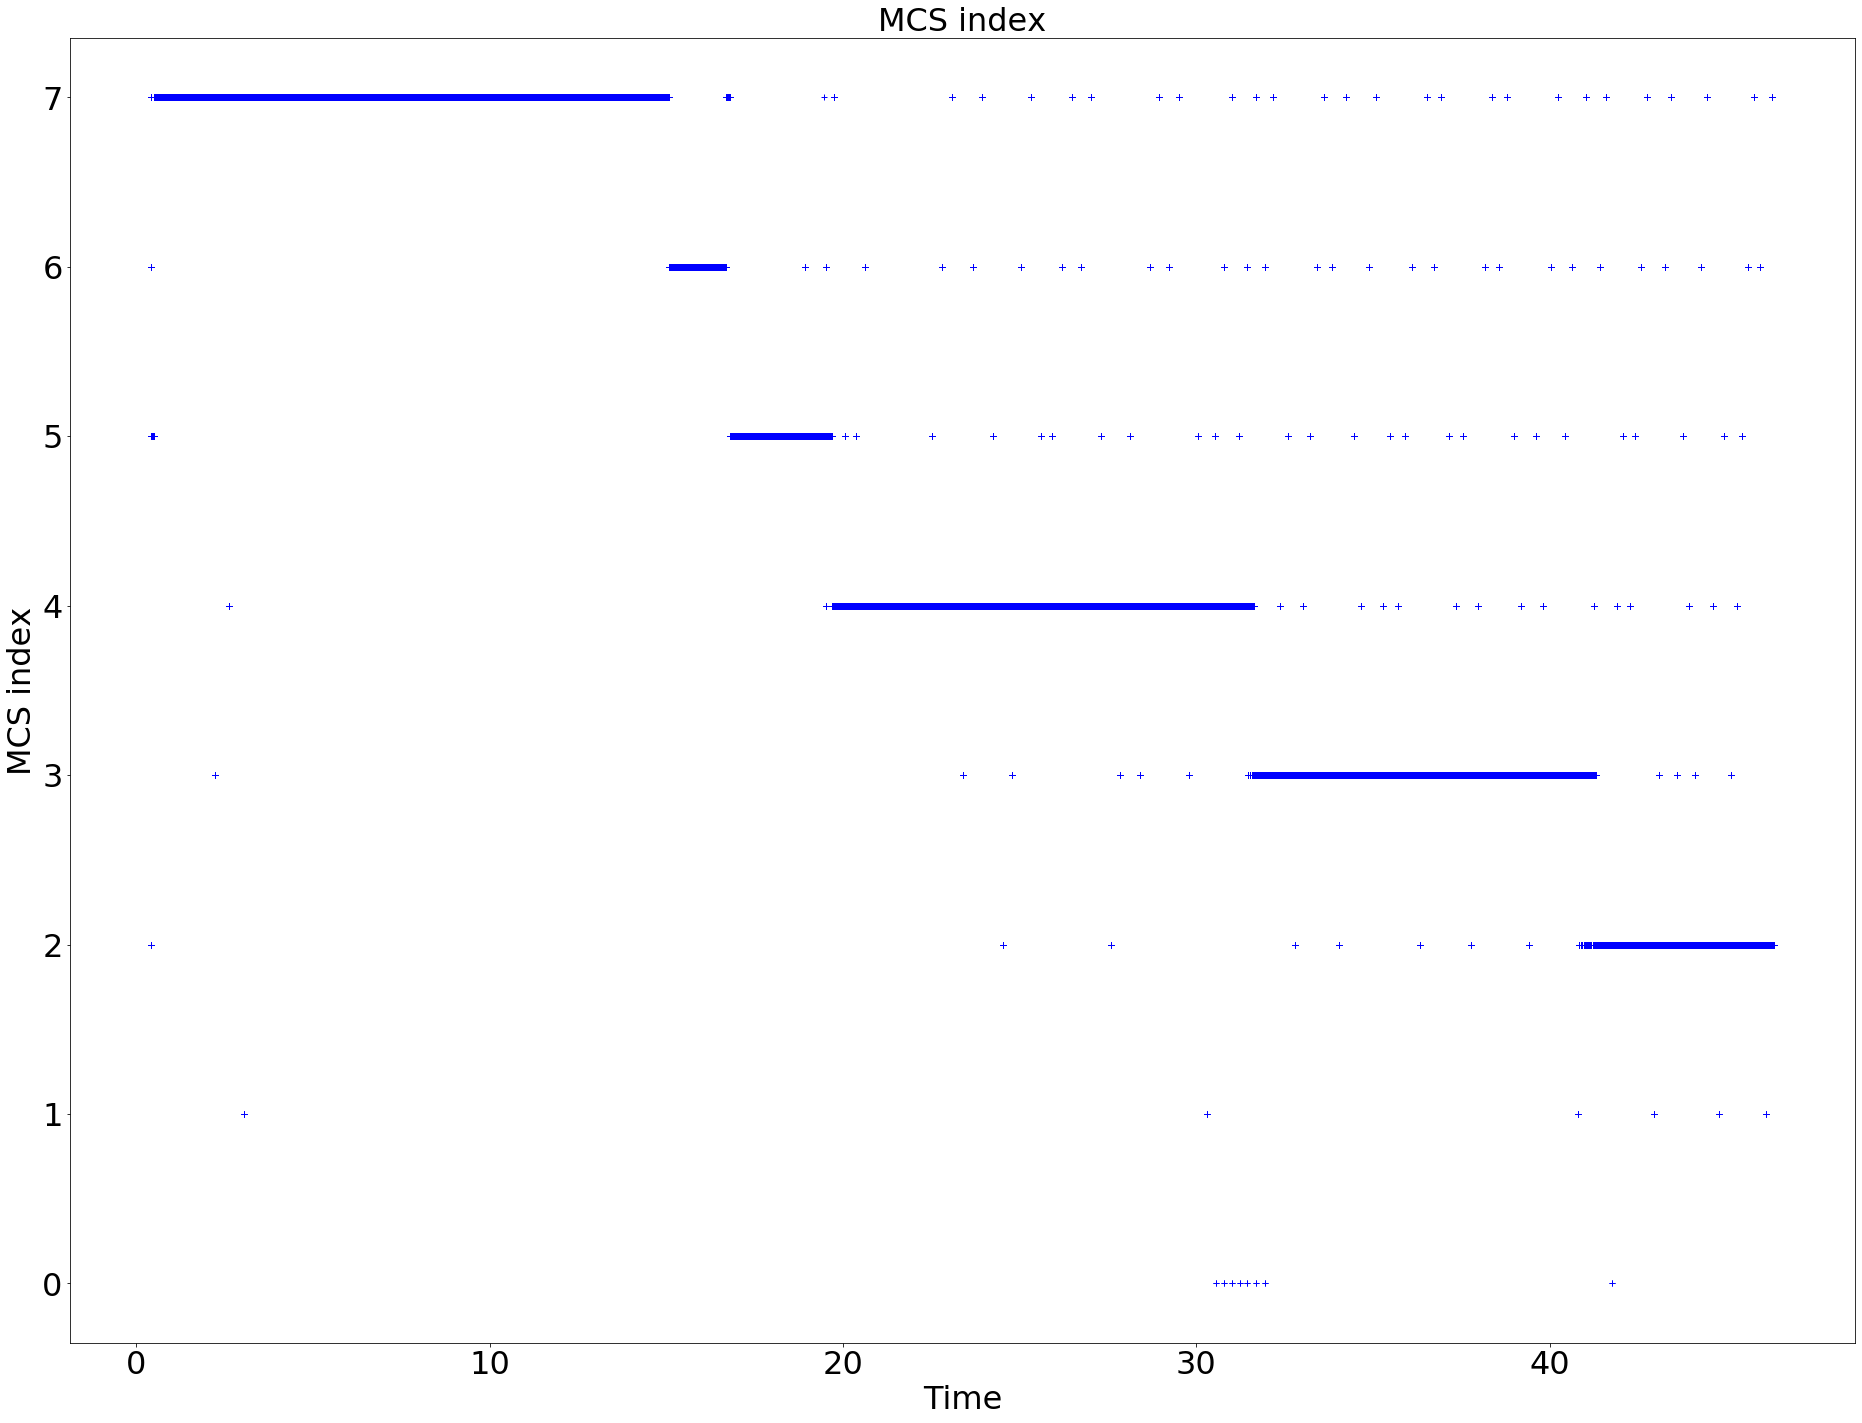

In [18]:
plt.figure(figsize=(32, 24))
plt.title("MCS index")
plt.plot(time, mcs_values, 'b+')
plt.title("MCS index", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Time", fontsize=32)
plt.ylabel("MCS index", fontsize=32)
plt.show()

In [19]:
start_time = sta_time.iloc[0]
print(start_time)

0.41137299999999993


### Calculate the throughput values for a 1 second window in time

In [20]:
throughput_values = []

curr_time = start_time
i = 0

n = len(sta_packets)
print(n)

while i < n:
    total_bytes = 0
    while i < n and (sta_time.iloc[i] <= curr_time + 1.0):
        total_bytes += sta_data.iloc[i]
        i += 1
    throughput_values.append(total_bytes*8/1000000)
    curr_time = sta_time.iloc[i-1]
    if i < n and sta_time.iloc[i] > curr_time + 1.0:
        throughput_values.append(0)
        i += 1

151021


In [21]:
print(len(throughput_values))
throughput = np.asarray(throughput_values)

47


### Plot the throughput values vs time

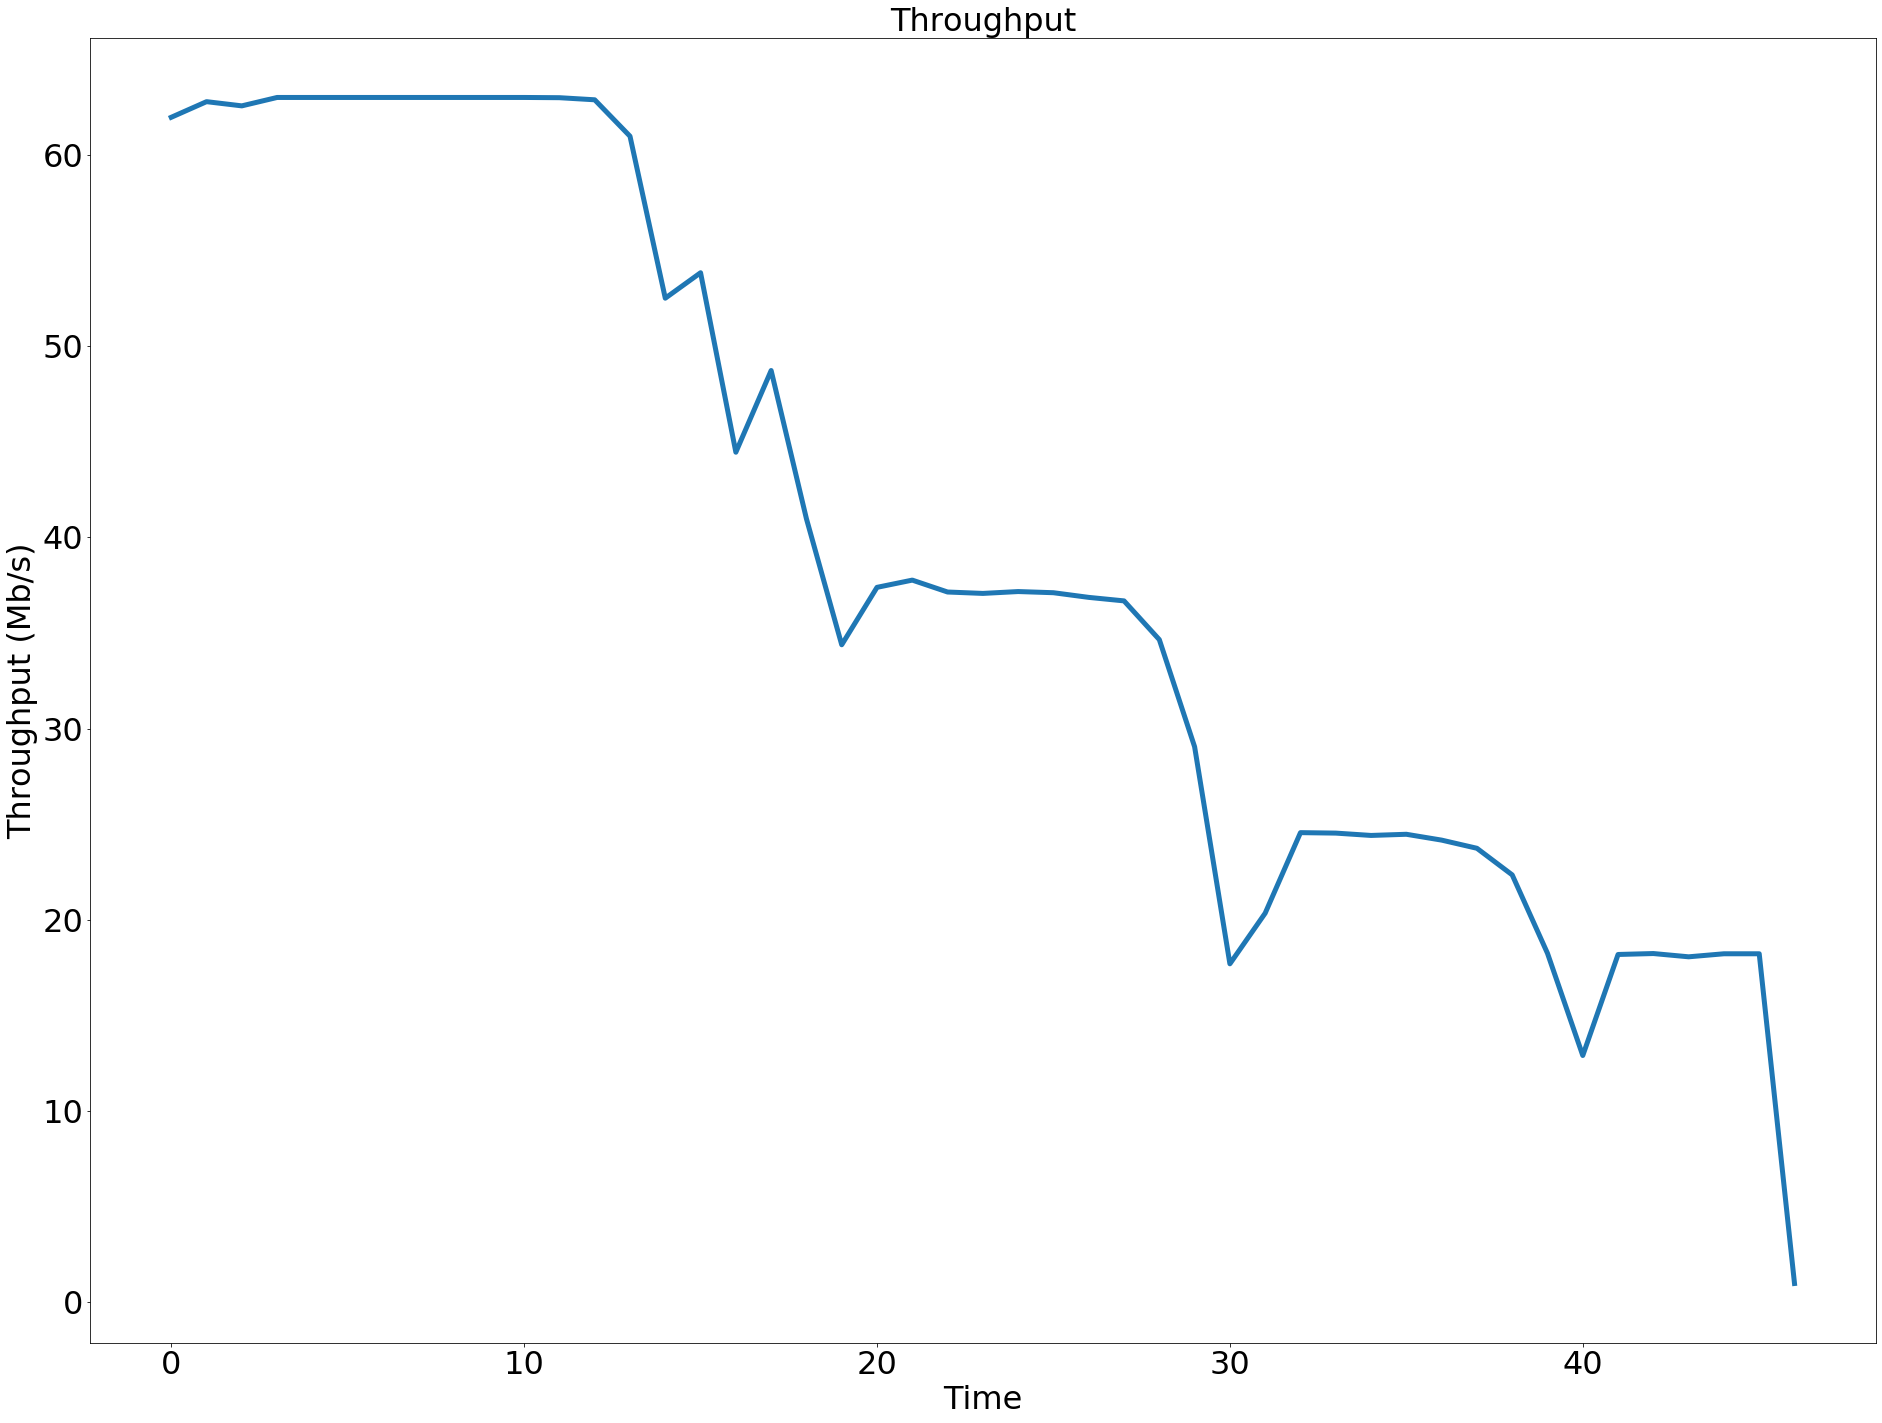

In [22]:
plt.figure(figsize=(32, 24))
plt.plot(throughput, linewidth=5)
plt.title("Throughput", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Time", fontsize=32)
plt.ylabel("Throughput (Mb/s)", fontsize=32)
plt.show()

In [23]:
print(ampdu_ref.isna().sum())

15


### Check if any packets are missing A-MPDU reference numbers

In [24]:
offset = 0
for i in range(0, len(ampdu_ref)):
    if np.isnan(ampdu_ref.iloc[i]):
        offset += 1
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i-1]) + 1
    else:
        ampdu_ref.iat[i] = int(ampdu_ref.iloc[i]) + offset

### Fill in the missing A-MPDU reference numbers

In [25]:
print(ampdu_ref.isna().sum())

0


In [26]:
print(ampdu_ref.tail())

170487    8544.0
170488    8544.0
170489    8544.0
170490    8544.0
170491    8544.0
Name: A-MPDU reference number, dtype: float64


### Calculate the A-MPDU size from the A-MPDU reference number of each MPDU

In [27]:
last_ampdu_ref = int(udp_packets.iloc[len(udp_packets) - 1]["A-MPDU reference number"])
print(last_ampdu_ref)
time_index = np.zeros(last_ampdu_ref + 1)
ampdu_sizes = np.zeros(last_ampdu_ref + 1)

for i in range(0, len(udp_packets)):
    current_ampdu_ref = int(ampdu_ref.iloc[i])
    if time_index[current_ampdu_ref] == 0:
        time_index[current_ampdu_ref] = time.iloc[i]
    if current_ampdu_ref >= 0:
        ampdu_sizes[current_ampdu_ref] += 1

8544


### Plot the A-MPDU size vs time

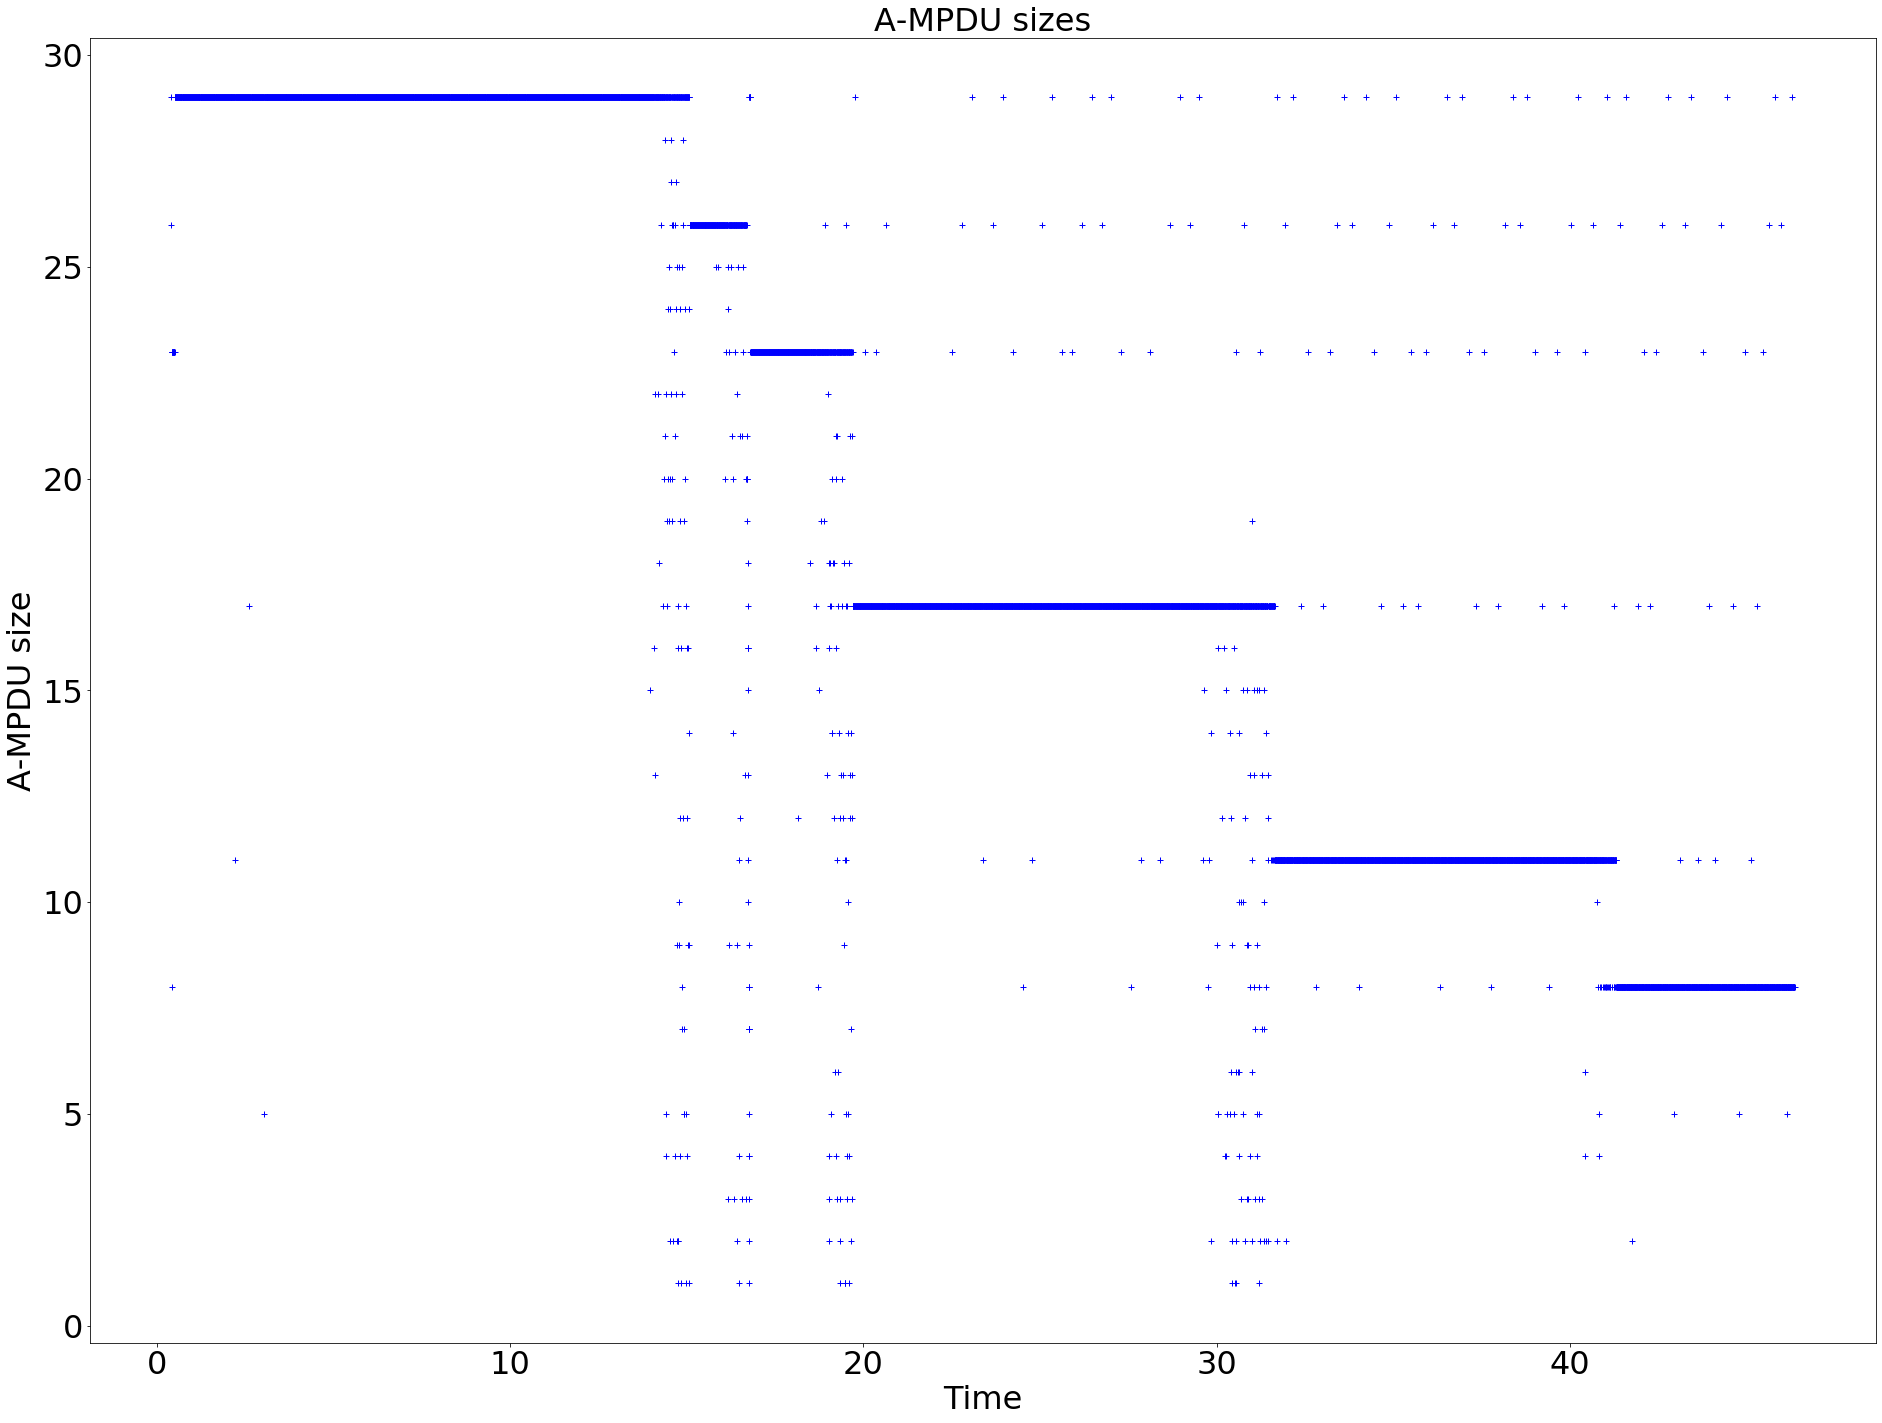

In [28]:
plt.figure(figsize=(32, 24))
plt.plot(time_index, ampdu_sizes, 'b+')
plt.title("A-MPDU sizes", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Time", fontsize=32)
plt.ylabel("A-MPDU size", fontsize=32)
plt.show()

### Write retry information into text file

In [29]:
file = open('minstrel_plus-retry-once/retry_information.txt', 'w')

for seq_number in range(0, len(new_sequence_numbers)):
    if num_retries[seq_number] > 0:
        file.write("This sequence number tries more than once: {}\n".format(seq_number))
        file.write("Information about all tries:\n")
        all_data = udp_packets[udp_packets["New Sequence number"] == seq_number]
        my_time = all_data["Time"]
        my_mcs = all_data["MCS index"]
        my_ampdu_ref = all_data["A-MPDU reference number"]
        for i in range(0, len(all_data)):
            file.write("Retry: {}\n".format(i+1))
            file.write("Time: {}\n".format(my_time.iloc[i]))
            file.write("MCS: {}\n".format(my_mcs.iloc[i]))
            file.write("A-MPDU size: {}\n".format(ampdu_sizes[int(my_ampdu_ref.iloc[i])]))

file.close()